 mlflow ui --backend-store-uri sqlite:///mlflow.db
mlflow

 mlflow ui --backend-store-uri sqlite:///mlflow.db

In [5]:

import mlflow
from pycaret.classification import *
from pycaret.regression import *
from sklearn.metrics import log_loss, f1_score
import pandas as pd
from datetime import datetime
import pycaret.classification as pc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import classification_report
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn import  metrics


In [39]:
# Carregar os dados
df_train = pd.read_parquet("../data/processed/base_train.parquet")
df_test = pd.read_parquet("../data/processed/base_test.parquet")


In [13]:
#df_test

In [14]:
#df_train

In [15]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Treinamento'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

In [16]:
url_docs_artefatos = "../docs/artefatos"

In [ ]:
#compare_models?

In [ ]:
#setup?


In [22]:
# Criar cópias dos DataFrames sem manter os índices originais
df_train_copy = df_train.copy().reset_index(drop=True)
df_test_copy = df_test.copy().reset_index(drop=True)


In [ ]:
# train/test
s = pc.setup(data = df_train, 
             target = 'shot_made_flag',
             train_size=0.7,
             verbose = 0,
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True )
models = ['lr','dt']

bestmodel = pc.compare_models(include = models, sort='precision')
# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc',
                        'pr',
                        'confusion_matrix'
                        'error', 
                        'class_report',
                        'threshold',
                         'learning',
                         'vc',
                        'feature',
                       ]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        
        temp_file =  f"{url_docs_artefatos}/graficos/treinamento/{plot_type}"
        plt.savefig(temp_file)
        mlflow.log_artifact(temp_file, artifact_path=plot_type)
        
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue






#Inicio projeto


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5731,0.5935,0.4825,0.5622,0.5193,0.1393,0.1406
1,0.5942,0.6231,0.4825,0.5928,0.5320,0.1804,0.1834
2,0.5836,0.6043,0.5166,0.5703,0.5421,0.1621,0.1627
3,0.6048,0.6194,0.5074,0.6018,0.5506,0.2024,0.2047
4,0.5933,0.6148,0.5092,0.5847,0.5444,0.1803,0.1817
5,0.5449,0.5726,0.4686,0.5259,0.4956,0.0835,0.0840
6,0.5731,0.5895,0.4852,0.5608,0.5203,0.1393,0.1404
7,0.5731,0.6088,0.4797,0.5616,0.5174,0.1388,0.1402
8,0.5739,0.5924,0.4686,0.5644,0.5121,0.1397,0.1416


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5484,0.5571,0.5120,0.5285,0.5201,0.0939,0.0939
1,0.6004,0.6094,0.5562,0.5864,0.5709,0.1974,0.1977
2,0.5801,0.5839,0.5480,0.5614,0.5546,0.1576,0.1576
3,0.5783,0.5950,0.5369,0.5607,0.5485,0.1533,0.1535
4,0.5572,0.5910,0.5203,0.5371,0.5286,0.1114,0.1114
5,0.5440,0.5547,0.5055,0.5229,0.5141,0.0848,0.0848
6,0.5555,0.5586,0.5037,0.5363,0.5195,0.1067,0.1069
7,0.5651,0.5782,0.5314,0.5455,0.5383,0.1275,0.1275
8,0.5484,0.5676,0.5203,0.5271,0.5237,0.0944,0.0944


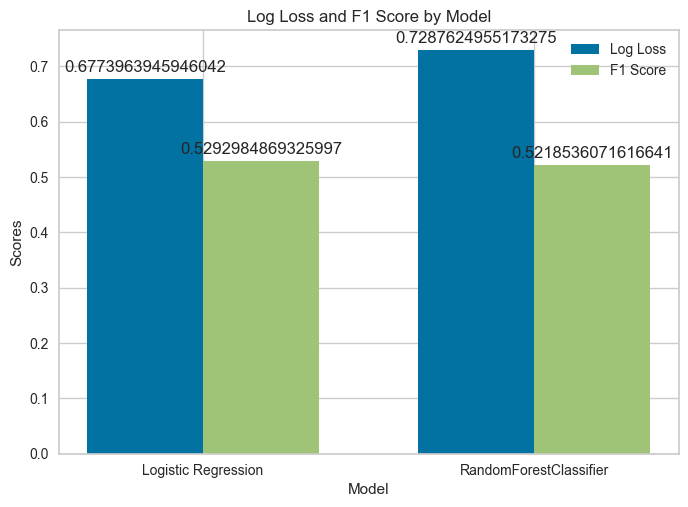

In [14]:
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # Adicionando RandomForestClassifier
from sklearn.metrics import log_loss, f1_score
from pycaret.classification import *
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt

# Carregar os dados
df_train = pd.read_parquet("../data/processed/base_train.parquet")
df_test = pd.read_parquet("../data/processed/base_test.parquet")

url_docs_artefatos = "../docs/artefatos"

# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Treinamento'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

# Verificar se já existe um run ativo
if mlflow.active_run():
    mlflow.end_run()

# Aguardar um pequeno atraso antes de iniciar o run no MLflow
time.sleep(2)

# Treinar um modelo de regressão logística com pyCaret
# Configure o ambiente do PyCaret
pc.setup(data=df_train, 
         target='shot_made_flag',
         train_size=0.7,
         verbose=0,
         log_experiment=True, 
         experiment_name=experiment_name, 
         log_plots=True)

# Criar modelos
lr = create_model('lr')
rf = create_model('rf')  # Adicionando RandomForestClassifier

# Finalizar o ambiente do PyCaret
finalize_model(lr)  # Logistic Regression"
finalize_model(rf)  # Finalizar o modelo RandomForestClassifier

# Remover a coluna alvo do conjunto de teste
df_test_features = df_test.drop(columns=['shot_made_flag'])

# Fazer previsões usando os modelos treinados
y_pred_proba_lr = lr.predict_proba(df_test_features)
y_pred_proba_rf = rf.predict_proba(df_test_features)
y_pred_lr = lr.predict(df_test_features)
y_pred_rf = rf.predict(df_test_features)

# Calcular as métricas log_loss e f1_score para o modelo de regressão logística
log_loss_lr = log_loss(df_test['shot_made_flag'], y_pred_proba_lr)
f1_score_lr = f1_score(df_test['shot_made_flag'], y_pred_lr)

# Calcular as métricas log_loss e f1_score para o modelo RandomForestClassifier
log_loss_rf = log_loss(df_test['shot_made_flag'], y_pred_proba_rf)
f1_score_rf = f1_score(df_test['shot_made_flag'], y_pred_rf)

# Registrar as métricas no MLflow
mlflow.log_metric("log_loss_lr", log_loss_lr)
mlflow.log_metric("f1_score_lr", f1_score_lr)
mlflow.log_metric("log_loss_rf", log_loss_rf)
mlflow.log_metric("f1_score_rf", f1_score_rf)

# Determinar o melhor modelo
best_model = "Logistic Regression" if f1_score_lr > f1_score_rf else "RandomForestClassifier"
best_model_version = lr if best_model == "Logistic Regression" else rf

# Registrar a versão do melhor modelo no MLflow
mlflow.sklearn.log_model(best_model_version, "best_model")


# Nomes dos modelos
models = ['Logistic Regression', 'RandomForestClassifier']

# Valores das métricas
log_loss_values = [log_loss_lr, log_loss_rf]
f1_score_values = [f1_score_lr, f1_score_rf]

# Criar o gráfico de barras
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, log_loss_values, width, label='Log Loss')
bars2 = ax.bar(x + width/2, f1_score_values, width, label='F1 Score')

# Adicionar rótulos, título e legendas
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Log Loss and F1 Score by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adicionar valores nas barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Salvar o gráfico como arquivo de imagem
temp_file =  f"{url_docs_artefatos}/graficos/treinamento/log_loss_f1.png"
plt.savefig(temp_file)
mlflow.log_artifact(temp_file, artifact_path='log_loss_f1.png')
        
plt.show()

In [44]:
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, f1_score
from pycaret.classification import *
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Carregar os dados
df_train = pd.read_parquet("../data/processed/base_train.parquet")
df_test = pd.read_parquet("../data/processed/base_test.parquet")

url_docs_artefatos = "../docs/artefatos/graficos/treinamento"

# Para usar o sqlite como repositório
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Treinamento'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

# Verificar se já existe um run ativo
if mlflow.active_run():
    mlflow.end_run()

# Aguardar um pequeno atraso antes de iniciar o run no MLflow
time.sleep(2)

# Treinar um modelo de regressão logística com pyCaret
# Configure o ambiente do PyCaret
pc.setup(data=df_train, 
         target='shot_made_flag',
         train_size=0.7,
         verbose=0,
         log_experiment=True, 
         experiment_name=experiment_name, 
         log_plots=True)

# Criar modelos
lr = create_model('lr')
rf = create_model('rf')  # Adicionando RandomForestClassifier

# Finalizar o ambiente do PyCaret
finalize_model(lr)
finalize_model(rf)

# Remover a coluna alvo do conjunto de teste
df_test_features = df_test.drop(columns=['shot_made_flag'])

# Fazer previsões usando os modelos treinados
y_pred_proba_lr = lr.predict_proba(df_test_features)
y_pred_proba_rf = rf.predict_proba(df_test_features)
y_pred_lr = lr.predict(df_test_features)
y_pred_rf = rf.predict(df_test_features)

# Calcular as métricas log_loss e f1_score para o modelo de regressão logística
log_loss_lr = log_loss(df_test['shot_made_flag'], y_pred_proba_lr)
f1_score_lr = f1_score(df_test['shot_made_flag'], y_pred_lr)

# Calcular as métricas log_loss e f1_score para o modelo RandomForestClassifier
log_loss_rf = log_loss(df_test['shot_made_flag'], y_pred_proba_rf)
f1_score_rf = f1_score(df_test['shot_made_flag'], y_pred_rf)

# Registrar as métricas no MLflow
mlflow.log_metric("log_loss_lr", log_loss_lr)
mlflow.log_metric("f1_score_lr", f1_score_lr)
mlflow.log_metric("log_loss_rf", log_loss_rf)
mlflow.log_metric("f1_score_rf", f1_score_rf)
# Calcular as métricas de precision, recall e matriz de confusão para o modelo de regressão logística
precision_lr = precision_score(df_test['shot_made_flag'], y_pred_lr)
recall_lr = recall_score(df_test['shot_made_flag'], y_pred_lr)
conf_matrix_lr = confusion_matrix(df_test['shot_made_flag'], y_pred_lr)

# Calcular as métricas de precision, recall e matriz de confusão para o modelo RandomForestClassifier
precision_rf = precision_score(df_test['shot_made_flag'], y_pred_rf)
recall_rf = recall_score(df_test['shot_made_flag'], y_pred_rf)
conf_matrix_rf = confusion_matrix(df_test['shot_made_flag'], y_pred_rf)

# Registrar as métricas no MLflow
mlflow.log_metric("precision_lr", precision_lr)
mlflow.log_metric("recall_lr", recall_lr)
mlflow.log_metric("precision_rf", precision_rf)
mlflow.log_metric("recall_rf", recall_rf)

# Plotar e salvar a matriz de confusão como gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(f"{url_docs_artefatos}/confusion_matrix_lr.png")
mlflow.log_artifact(f"{url_docs_artefatos}/confusion_matrix_lr.png", artifact_path='confusion_matrix_lr.png')


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão - RandomForestClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig(f"{url_docs_artefatos}/confusion_matrix_rf.png")
mlflow.log_artifact(f"{url_docs_artefatos}/confusion_matrix_rf.png", artifact_path='confusion_matrix_rf.png')

# Extrair métricas do classification_report
precision_lr, recall_lr, f1_score_lr, _ = classification_report(df_test['shot_made_flag'], y_pred_lr, output_dict=True)['weighted avg'].values()

# Criar gráfico de barras para as métricas
metrics = ['Precision', 'Recall', 'F1 Score']
scores_lr = [precision_lr, recall_lr, f1_score_lr]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores_lr, color=['blue', 'green', 'red'])
plt.title('Classification Report - Logistic Regression')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0.0, 1.0)
plt.savefig(f"{url_docs_artefatos}/classification_report_lr.png")
mlflow.log_artifact(f"{url_docs_artefatos}/classification_report_lr.png", artifact_path='classification_report_lr.png')
plt.show()

# Extrair métricas do classification_report para RandomForestClassifier
precision_rf, recall_rf, f1_score_rf, _ = classification_report(df_test['shot_made_flag'], y_pred_rf, output_dict=True)['weighted avg'].values()

# Criar gráfico de barras para as métricas
scores_rf = [precision_rf, recall_rf, f1_score_rf]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores_rf, color=['blue', 'green', 'red'])
plt.title('Classification Report - RandomForestClassifier')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0.0, 1.0)
plt.savefig(f"{url_docs_artefatos}/classification_report_rf.png")
mlflow.log_artifact(f"{url_docs_artefatos}/classification_report_rf.png", artifact_path='classification_report_rf.png')
plt.show()

# Calcular a curva ROC para o modelo de regressão logística
fpr_lr, tpr_lr, thresholds_lr = roc_curve(df_test['shot_made_flag'], y_pred_proba_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calcular a curva ROC para o modelo RandomForestClassifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(df_test['shot_made_flag'], y_pred_proba_rf[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig(f"{url_docs_artefatos}/roc_curve.png")
mlflow.log_artifact(f"{url_docs_artefatos}/roc_curve.png", artifact_path='roc_curve.png')
plt.show()

# Determinar o melhor modelo
best_model = "Logistic Regression" if f1_score_lr > f1_score_rf else "RandomForestClassifier"
best_model_version = lr if best_model == "Logistic Regression" else rf

# Registrar a versão do melhor modelo no MLflow
mlflow.sklearn.log_model(best_model_version, "best_model")

# Plotar curva de aprendizado
def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizado")
    plt.xlabel("Tamanho do Conjunto de Treinamento")
    plt.ylabel("Accuracy Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Pontuação de Treinamento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Pontuação de Teste")
    plt.legend(loc="best")
    plt.savefig(f"{url_docs_artefatos}/learning_curve.png")
    mlflow.log_artifact(f"{url_docs_artefatos}/learning_curve.png", artifact_path='learning_curve.png')
    plt.show()

# Plotar curva de validação
def plot_validation_curve(estimator, X, y, param_name, param_range, cv=None):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Curva de Validação")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Pontuação de Treinamento",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Pontuação de Teste",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.savefig(f"{url_docs_artefatos}/validation_curve.png")
    mlflow.log_artifact(f"{url_docs_artefatos}/validation_curve.png", artifact_path='validation_curve.png')
    plt.show()

# Plotar curva de aprendizado e curva de validação
plot_learning_curve(best_model_version, df_train.drop(columns=['shot_made_flag']), df_train['shot_made_flag'])
#plot_validation_curve(best_model_version, df_train.drop(columns=['shot_made_flag']), df_train['shot_made_flag'],"C", np.arange(1, 100, 10))
                    
plot_validation_curve(best_model_version, df_train.drop(columns=['shot_made_flag']), df_train['shot_made_flag'],"C", np.logspace(-3, 3, 7))

plt.show()


ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/Users/wolfx/Documents/python/Pos IA/engenharia_machine_learning/eng_machine_learning/virtual/lib/python3.11/site-packages/sklearn/metrics/__init__.py)